In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevels = percents = [0.1, 0.01]

alpha = 1 # proximal term coefficient

num_agents = num_packages = 200
num_fcs = 50

filename = "local_ap_N%d_%s_n%d_m%d"%(num_points, ",".join(list(map(str, eps_sublevels))), num_agents, num_fcs)

In [4]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_xp, true_xf, true_f, true_lamb, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  integer=False)
print(f"{true_f=}")

true_f=-90.29596235198767


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.12754546028331876

In [7]:
true_lamb.shape, true_xp.shape, true_xf.shape

((50,), (200, 50), (50,))

In [8]:
fun_agents_eps = {}
fun_agents_noisy_y = {}
for eps in percents:
    fun_agents_eps[eps] = []
    fun_agents_noisy_y[eps] = []
    for i in range(num_packages):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                    econ, eps_sublevel=eps, K=K, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                    econ, percent=eps, K=K, return_best=True)]
    
    for i in range(num_packages, num_packages+num_fcs):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                            econ, eps_sublevel=eps, K=K, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                            econ, percent=eps, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [10]:
all_results_eps = {}
all_results_noisy_y = {}
for eps in percents:
    print(f"{eps=}")
    all_results_eps[eps]  = mra.price_localization_primal_recovery(fun_agents_eps[eps], fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[eps]  = mra.price_localization_primal_recovery(fun_agents_noisy_y[eps], fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

eps=0.1


/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.0444E+00,  viol_xk=1.3706E+02, viol_mra=1.0278E+02, lamb_rel_diff=INF
epoch=15, f_subopt_xk=2.1195E-02,  f_subopt_mra=4.3802E-02,  viol_xk=7.8628E+01, viol_mra=8.7045E-10, lamb_rel_diff=5.8851E-02
terminate with lamb_rel_diff=0.05885063123796142
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.2548E+00,  viol_xk=1.3706E+02, viol_mra=1.3256E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.5051E-03,  f_subopt_mra=8.7981E-03,  viol_xk=7.1921E+01, viol_mra=9.7300E+00, lamb_rel_diff=5.4798E-02
epoch=71, f_subopt_xk=9.4848E-03,  f_subopt_mra=8.8010E-03,  viol_xk=6.2050E+01, viol_mra=1.1497E-10, lamb_rel_diff=4.7269E-02
terminate with lamb_rel_diff=0.047268737386429234
eps=0.01
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.1946E+00,  viol_xk=1.3706E+02, viol_mra=1.2622E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.5050E-03,  f_subopt_mra=4.3191E-03,  viol_xk=7.1921E+01, viol_mra=3.8004E+01, lamb_rel_diff=5.4798E-02
epoch=100, f_subopt_xk=4.78

In [11]:
eps = max(percents)
if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
    all_res = all_results_noisy_y[eps]
else:
    all_res = all_results_eps[eps]

In [12]:
for i, eps in enumerate(percents):
      print(np.array(all_res["viol_primal_xk"])[-1] ,
      "sub_eps", np.array(all_results_eps[eps]["viol_primal_mra_xk"])[-1] ,
      "noisy_y", np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"])[-1] )

29.175003271109873 sub_eps 5.588956519808619e-10 noisy_y 7.244066457801068e-11
29.175003271109873 sub_eps 4.5855335500943895e-10 noisy_y 0.9363264639757728


In [13]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle


with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    eps = max(percents)
    if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
        all_res = all_results_noisy_y[eps]
    else:
        all_res = all_results_eps[eps]


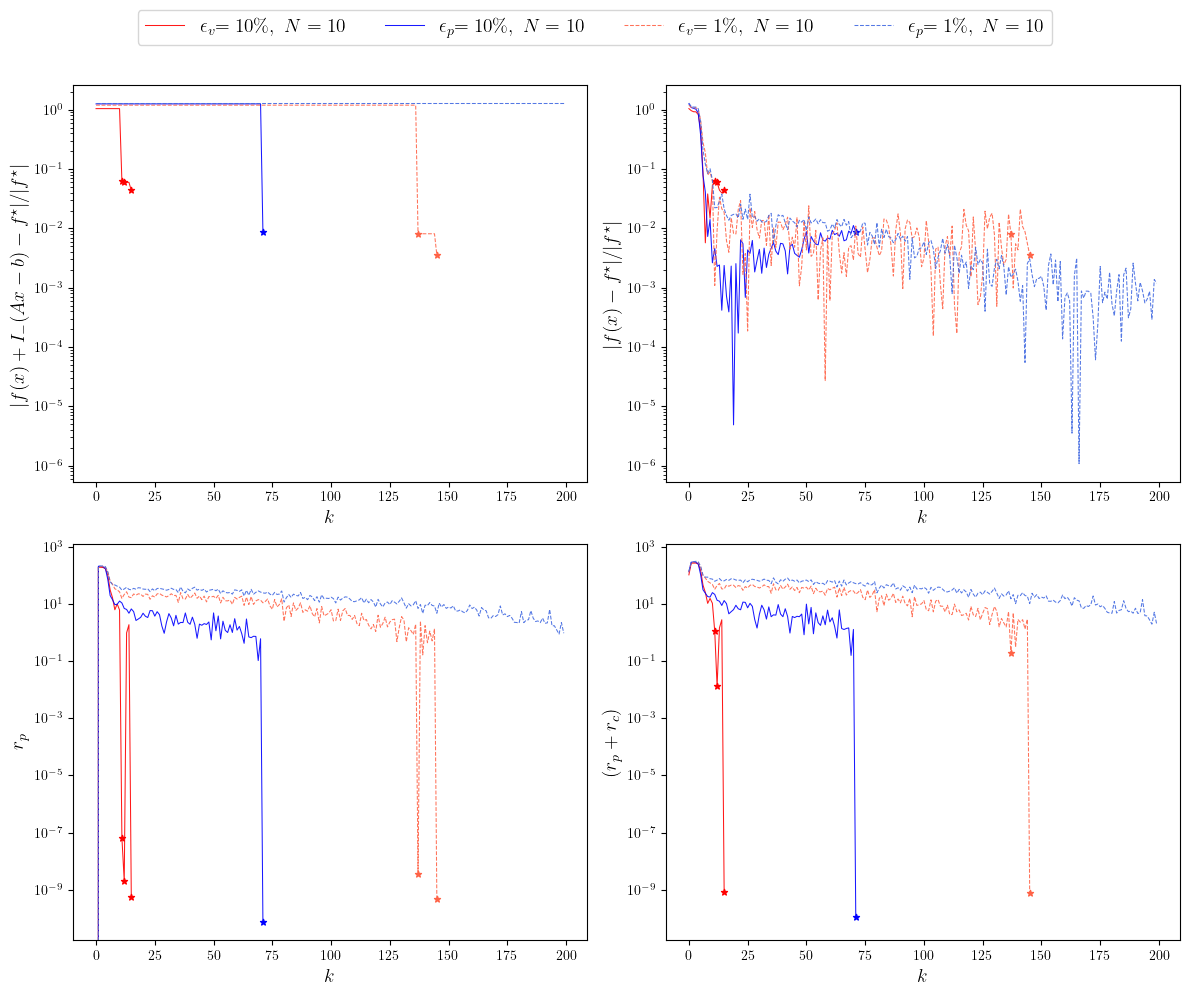

In [7]:
mra.plot_eps_all_metrics_4x(all_results_eps, all_results_noisy_y, num_points, true_f, b_norm, percents, filename)

In [9]:
for eps in percents:
    print(f"{eps=}")
    eps_subopt = (np.abs(np.array(all_results_eps[eps]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    eps_res = np.array(all_results_eps[eps]["viol_primal_mra_xk"]) 
    noisy_y_subopt = (np.abs(np.array(all_results_noisy_y[eps]["f_mra_xk"]) - true_f)) / np.abs(true_f)
    noisy_y_res = np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"]) 

    res_tol = 1e-6
    print("eps", np.where(eps_res < res_tol)[0][0],  "noisy_y", np.where(noisy_y_res < res_tol)[0][0])

    eps_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_eps[eps], true_f, 1),)
    noisy_y_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_noisy_y[eps], true_f, 1),)

    print(f"eps {eps_subopt[-1]*100}\%  noisy_y {noisy_y_subopt[-1]*100}\%")

eps=0.1
eps 0 noisy_y 0
eps 4.380207425851541\%  noisy_y 0.8801012707266501\%
eps=0.01
eps 0 noisy_y 0
eps 0.3553569808590352\%  noisy_y 129.78107350780542\%
